
# WIRE Wallet — Scaling Pipelines (MinMax vs Standard vs Hybrid)

This notebook loads your engineered dataset and produces three scaled versions:

1. **All-MinMax** → `_minmax.csv` (baseline / current)  
2. **All-Standard** → `_standard.csv`  
3. **Hybrid (log+Robust + Standard + Passthrough + cyclical)** → `_hybrid.csv` (**recommended**)  

It also persists the fitted preprocessors with joblib so you can reuse them in your training and serving pipelines.


In [1]:

# ==== Configuration ====
INPUT_CSV = "../../data/combined_wallets_with_transactions_and_balances_2.csv"  # change if needed
OUTPUT_MINMAX = "../../data/combined_wallets_with_transactions_and_balances_minmax.csv"
OUTPUT_STANDARD = "../../data/combined_wallets_with_transactions_and_balances_standard.csv"
OUTPUT_HYBRID = "../../data/combined_wallets_with_transactions_and_balances_hybrid.csv"

SCALER_MINMAX_PATH = "../../models/preprocessor_minmax.pkl"
SCALER_STANDARD_PATH = "../../models/preprocessor_standard.pkl"
SCALER_HYBRID_PATH = "../../models/preprocessor_hybrid.pkl"

RANDOM_STATE = 42


In [2]:

import pandas as pd
import numpy as np
from pathlib import Path

from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, FunctionTransformer
from sklearn.pipeline import Pipeline
import joblib

import matplotlib.pyplot as plt


In [3]:

# ==== Load ====
df = pd.read_csv(INPUT_CSV)
print("Loaded:", INPUT_CSV)
print("Rows, Cols:", df.shape)
print("\nColumns:", list(df.columns))

label_col = "isSafe" if "isSafe" in df.columns else None
raw_df = df.copy()

# ==== Feature Columns ====
all_features = [
    'noOfTrx.1', 'Balance', 'self_transfer_ratio', 'circular_txn_count',
    'circular_txn_ratio', 'avg_txn_value_eth', 'txn_spike_score',
    'value_std_dev', 'avg_gas_used', 'avg_gas_price', 'active_days',
    'wallet_age_days', 'unique_counterparties', 'failed_txn_ratio',
    'eth_inflow_outflow_ratio', 'erc20_txn_count', 'nft_txn_count',
    'first_txn_time_of_day', 'erc20_token_diversity', 'tx_direction_ratio',
    'contract_interaction_ratio', 'value_entropy', 'average_txn_interval',
    'new_token_interaction_count', 'token_approval_count',
    'sbt_poap_event_count'
]
features = [c for c in all_features if c in df.columns]
missing = [c for c in all_features if c not in df.columns]
if missing:
    print("Warning: missing columns (will be skipped):", missing)

# Ensure numeric features before any scaling
X = df[features].apply(pd.to_numeric, errors='coerce').fillna(0.0)


Loaded: ../../data/combined_wallets_with_transactions_and_balances_2.csv
Rows, Cols: (33749, 34)

Columns: ['Address', 'Name', 'isSafe', 'Tags', 'Transactions', 'noOfTrx.1', 'Balance', 'total_transactions', 'self_transfer_ratio', 'circular_txn_count', 'circular_txn_ratio', 'avg_txn_value_eth', 'txn_spike_score', 'value_std_dev', 'avg_gas_used', 'avg_gas_price', 'active_days', 'wallet_age_days', 'unique_counterparties', 'failed_txn_ratio', 'eth_inflow_outflow_ratio', 'erc20_txn_count', 'nft_txn_count', 'first_txn_time_of_day', 'erc20_token_diversity', 'tx_direction_ratio', 'contract_interaction_ratio', 'value_entropy', 'tx_burst_count', 'average_txn_interval', 'new_token_interaction_count', 'token_approval_count', 'sbt_poap_event_count', 'approved_token_list']


In [4]:

# --- Safe numeric functions for FunctionTransformer ---
from sklearn.preprocessing import FunctionTransformer, RobustScaler, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def safe_log1p(X):
    X = pd.DataFrame(X)
    X = X.apply(pd.to_numeric, errors='coerce').fillna(0.0)
    X = np.nan_to_num(X.to_numpy(dtype=float), nan=0.0, posinf=0.0, neginf=0.0)
    X = np.clip(X, 0.0, None)
    return np.log1p(X)

def hour_to_sin_cos(X):
    X = pd.DataFrame(X).apply(pd.to_numeric, errors='coerce').fillna(0.0)
    arr = np.nan_to_num(X.to_numpy(dtype=float), nan=0.0)
    arr = np.clip(arr, 0, 23)
    sin = np.sin(2*np.pi*arr/24.0)
    cos = np.cos(2*np.pi*arr/24.0)
    return np.concatenate([sin, cos], axis=1)

# Column groups
log_robust_cols = [c for c in ["Balance","noOfTrx.1","avg_txn_value_eth","value_std_dev","average_txn_interval"] if c in features]
std_cols        = [c for c in ["active_days","wallet_age_days","unique_counterparties","avg_gas_used","avg_gas_price"] if c in features]
cyc_cols        = [c for c in ["first_txn_time_of_day"] if c in features]
cyc_and_scaled  = set(log_robust_cols + std_cols + cyc_cols)
passthrough_cols = [c for c in features if c not in cyc_and_scaled]

log_then_robust = Pipeline([
    ("log", FunctionTransformer(safe_log1p, validate=False)),
    ("robust", RobustScaler())
])
cyclical = FunctionTransformer(hour_to_sin_cos, validate=False)

# Three preprocessors
pre_minmax = ColumnTransformer([("mm", MinMaxScaler(), features)], remainder="drop")
pre_standard = ColumnTransformer([("std", StandardScaler(), features)], remainder="drop")
pre_hybrid = ColumnTransformer(
    transformers=[
        ("log_robust", log_then_robust, log_robust_cols),
        ("standard", StandardScaler(), std_cols),
        ("cyclical", cyclical, cyc_cols),
        ("passthrough", "passthrough", passthrough_cols),
    ],
    remainder="drop"
)

print("Hybrid groups:")
print("  log+robust:", log_robust_cols)
print("  standard  :", std_cols)
print("  cyclical  :", cyc_cols, "-> (sin, cos)")
print("  passthrough:", passthrough_cols)


Hybrid groups:
  log+robust: ['Balance', 'noOfTrx.1', 'avg_txn_value_eth', 'value_std_dev', 'average_txn_interval']
  standard  : ['active_days', 'wallet_age_days', 'unique_counterparties', 'avg_gas_used', 'avg_gas_price']
  cyclical  : ['first_txn_time_of_day'] -> (sin, cos)
  passthrough: ['self_transfer_ratio', 'circular_txn_count', 'circular_txn_ratio', 'txn_spike_score', 'failed_txn_ratio', 'eth_inflow_outflow_ratio', 'erc20_txn_count', 'nft_txn_count', 'erc20_token_diversity', 'tx_direction_ratio', 'contract_interaction_ratio', 'value_entropy', 'new_token_interaction_count', 'token_approval_count', 'sbt_poap_event_count']


In [5]:

from pathlib import Path

def fit_transform_and_export(preprocessor, X, base_df, out_csv, scaler_path):
    Xt = preprocessor.fit_transform(X)

    # Clean feature names: strip transformer prefixes like "mm__", "std__", "log_robust__"
    try:
        raw_names = list(preprocessor.get_feature_names_out())
        out_cols = []
        for n in raw_names:
            if n.startswith("cyclical__first_txn_time_of_day"):
                # last char is 0 or 1
                out_cols.append("first_txn_time_of_day_sin" if n.endswith("0") else "first_txn_time_of_day_cos")
            else:
                out_cols.append(n.split("__")[-1])  # keep only the base column name
    except Exception:
        out_cols = [f"f_{i}" for i in range(np.asarray(Xt).shape[1])]

    Xt_df = pd.DataFrame(Xt, index=base_df.index, columns=out_cols)

    out = pd.concat(
        [base_df.drop(columns=[c for c in features if c in base_df.columns], errors="ignore"), Xt_df],
        axis=1
    )

    from pathlib import Path
    Path(out_csv).parent.mkdir(parents=True, exist_ok=True)
    Path(scaler_path).parent.mkdir(parents=True, exist_ok=True)

    out.to_csv(out_csv, index=False)
    import joblib
    joblib.dump(preprocessor, scaler_path)

    print(f"Saved scaled CSV -> {out_csv}")
    print(f"Saved fitted preprocessor -> {scaler_path}")
    return out



In [6]:

print("\n=== Fitting All-MinMax ===")
out_minmax = fit_transform_and_export(pre_minmax, X, raw_df, OUTPUT_MINMAX, SCALER_MINMAX_PATH)

print("\n=== Fitting All-Standard ===")
out_standard = fit_transform_and_export(pre_standard, X, raw_df, OUTPUT_STANDARD, SCALER_STANDARD_PATH)

print("\n=== Fitting HYBRID (recommended) ===")
out_hybrid = fit_transform_and_export(pre_hybrid, X, raw_df, OUTPUT_HYBRID, SCALER_HYBRID_PATH)



=== Fitting All-MinMax ===
Saved scaled CSV -> ../../data/combined_wallets_with_transactions_and_balances_minmax.csv
Saved fitted preprocessor -> ../../models/preprocessor_minmax.pkl

=== Fitting All-Standard ===
Saved scaled CSV -> ../../data/combined_wallets_with_transactions_and_balances_standard.csv
Saved fitted preprocessor -> ../../models/preprocessor_standard.pkl

=== Fitting HYBRID (recommended) ===
Saved scaled CSV -> ../../data/combined_wallets_with_transactions_and_balances_hybrid.csv
Saved fitted preprocessor -> ../../models/preprocessor_hybrid.pkl


[warn] Balance not found in df


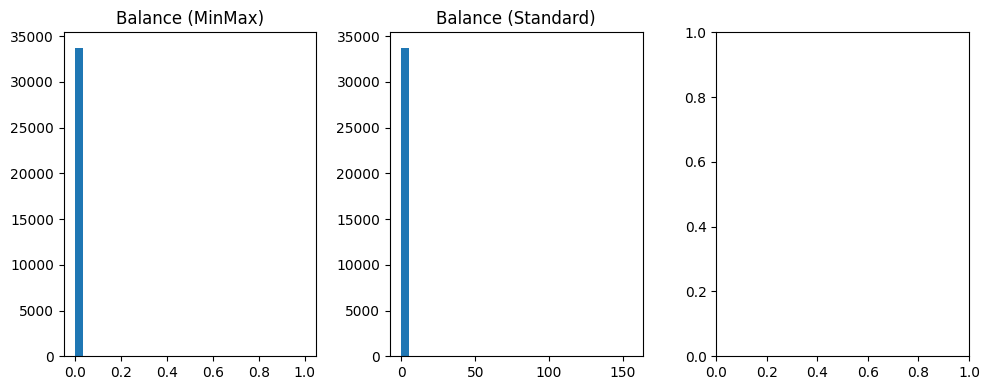

In [7]:
def hist_for_feature(df, base_name, bins=30, title=""):
    # find the first numeric column whose base name matches
    candidates = [c for c in df.columns if c.split("__")[-1] == base_name or base_name in c]
    col = None
    for c in candidates:
        if pd.api.types.is_numeric_dtype(df[c]):
            col = c; break
    if col is None:
        print(f"[warn] {base_name} not found in df"); return
    plt.hist(df[col].astype(float), bins=bins); plt.title(title or col)

plt.figure(figsize=(10,4))
plt.subplot(1,3,1); hist_for_feature(out_minmax,  "Balance", title="Balance (MinMax)")
plt.subplot(1,3,2); hist_for_feature(out_standard,"Balance", title="Balance (Standard)")
plt.subplot(1,3,3); hist_for_feature(out_hybrid,  "Balance", title="Balance (Hybrid)")
plt.tight_layout(); plt.show()